<a href="https://colab.research.google.com/github/alvesraisa/MinervaSatsGC/blob/main/Fire_Smoke_SIAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **##### ~~~~~~~Fire and Smoke Detection with Deep Learning (CNN)**


# **Clonando o repositório e instalando as dependências**
# *Clone Repo and install dependencies*

In [ ]:
!git clone https://github.com/ultralytics/yolov5   # modelo yolov5
!git clone https://github.com/AyushExel/yolov5.git --branch master
%cd /content/yolov5 # entrando no diretório criado yolov5
!pip install -r yolov5/requirements.txt
!pip install wandb # instalando o Weights and Biases (ver https://towardsdatascience.com/what-does-weights-biases-do-c060ce6b4b8e)

In [ ]:
import torch # importando o PyTorch
from IPython.display import Image, clear_output
from utils.downloads import gdrive_download # Para acessar o google drive

clear_output() #limpa a saída da célula

In [ ]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))    ## para ver a GPU utilizada (quando utilizada...)

# **Fazendo o download do banco de dados customizado**
# *Download the custom dataset*



In [ ]:
%cd /content # voltando para o diretório raiz \content
from google.colab import drive 
drive.mount("/content/gdrive/", force_remount=True) # monta a pasta do banco de dados do GDrive no GColab 
# Será pedido o  seu login no Google Drive

In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive 
!ls /mydrive  # vê todas as pastas que estão no seu Google Drive

In [ ]:
%cd /mydrive 

In [ ]:
%cd /mydrive/Custom_Dataset_MinervaSats # Entra na pasta do banco de dados que já deve estar dentro do Google Drive
!ls # Vê os arquivos que tem dentro da pasta, certifique-se

In [ ]:
#extrai a informação do arquivo data
#este arquivo deve constar o caminho das imagens, o número de classes e quais são as classes
%cat data.yaml 

In [ ]:
# define number of classes based on data.yaml
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#%cat /content/yolov5/models/yolov5s.yaml

# **Use a custom model configuration**

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml  #esse arquivo customizado .yaml deve ser criado e carregado na raiz \content
# Podemos customizar o arquivo de acordo com nosso número de classes...
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 2  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

%%writetemplate /content/yolov5/models/yolov5x.yaml

# Parameters
nc: 3  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
  

# **Train on new dataset**

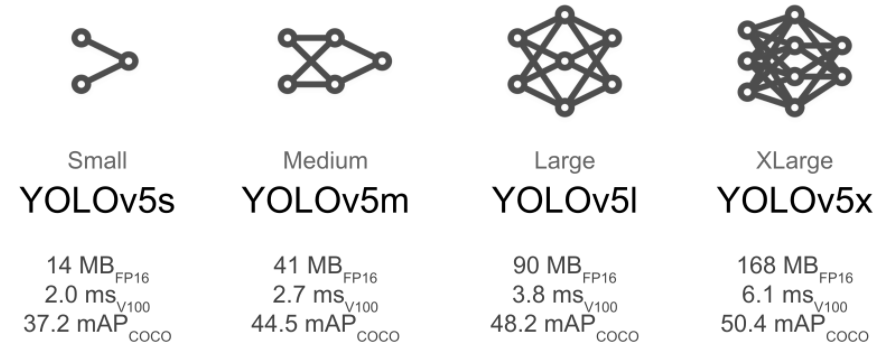

In [ ]:
# treinando yolov5l no dado customizado para 300 épocas (epochs)

%cd /content/yolov5/
!python train.py \
  --data ../dataset_cust.yaml \
  --img 416 \
  --epochs 300 \
  --bbox_interval 1 \
  --save-period 10 \
  --cfg ./models/yolov5s.yaml  \ #Ou muda para o modelo Large ou qualquer outro
  --weights yolov5l.pt \
  --name yolov5s_results_proprioDS \


 # --img 416 --batch 16 --epochs 100 --data ../custom_dataset_wandb.yaml --cfg ./models/yolov5x.yaml --weights '' --name yolov5x_results  --cache

In [ ]:
crashed_run_path = "catisa/custom_yolov5_siac/2lm1phrb" # Mudar para a pasta do seu projeto no Weights and Biases
!python train.py --resume wandb-artifact://{crashed_run_path}

In [ ]:
#Start tensorboard
#Launch after you have run training
#logs save in the folder run
%load_ext tensorboard
%tensorboard --logdir runs

# **Test on Images and Videos**

In [ ]:
##!python detect.py --weights runs/exp0_yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images 
#!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

In [ ]:
#import glob
#from IPython.display import Image, display

#for imageName in glob.glob('/content/yolov5/inference/output/*.jpg'):
#    display(Image(filename=imageName))
#    print("\n")

In [ ]:
#!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --source ../video_theguardian_sem.mp4 --conf 0.4